In [30]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import os,shutil,json
import argparse
import copy
import matplotlib.pyplot as plt

from statsmodels.stats.proportion import proportion_confint
import glob
import os
import copy
from scipy.special import comb
parser = argparse.ArgumentParser()
parser.add_argument("-ablation_ratio_test", type=float, default=0.0107)#for randomized_ablation
parser.add_argument("-ablation_ratio_test1", type=float, default=0.00859)#for MMCert
parser.add_argument("-ablation_ratio_test2", type=float, default=0.0129)#for MMCert
parser.add_argument("-r2_geq_r1", type=float, default=True)#for MMCert
parser.add_argument("-r1_r2_ratio", type=int, default=3)#for MMCert
parser.add_argument("-inverse_r1_r2_ratio", type=int, default=2)#for MMCert
parser.add_argument("-alpha", type=float, default=0.001)
parser.add_argument("-c", type=float, help="number of test samples", default=58)
parser.add_argument("-num_ablated_inputs", type=int, default=100)

def plot_tensor_image(tensor_image, batch_idx=0):
    # If tensor has more than 2 dimensions, select the batch index
    if len(tensor_image.shape) > 2:
        tensor_image = tensor_image[batch_idx]
    
    # Convert tensor to numpy array
    image_array = tensor_image.detach().cpu().numpy()

    # Plot the image
    plt.imshow(image_array, cmap='gray')
    plt.colorbar()
    plt.show()
def _lower_confidence_bound(NA: int, N: int, alpha: float) -> float:
        """ Returns a (1 - alpha) lower confidence bound on a bernoulli proportion.
        This function uses the Clopper-Pearson method.
        :param NA: the number of "successes"
        :param N: the number of total draws
        :param alpha: the confidence level
        :return: a lower bound on the binomial proportion which holds true w.p at least (1 - alpha) over the samples
        """
        return proportion_confint(NA, N, alpha, method="beta")
def get_bound_list(args):
    l =[]
    for i in range(101):
        lower,upper = _lower_confidence_bound(i, args.num_ablated_inputs, args.alpha)
        l.append((lower,upper))
    return l

def get_bounds1(args, counts, bound_list):
    bound_array = np.array(bound_list)  # Convert list of tuples to 2D numpy array

    # Index into bound_array using counts to fetch the corresponding bounds
    lower_bounds = bound_array[counts][:, :, :, 0]
    upper_bounds = bound_array[counts][:, :, :, 1]

    return lower_bounds, upper_bounds

def get_certified_pixels(all_gt,lower_positive,upper_positive,lower_negative,upper_negative):
    certified_pixels = np.zeros((58,375,1242))
    for k in range(58):
        print(k)
        for i in range(375):
            for j in range(1242):
                if all_gt[k][i][j] ==0:
                    if lower_negative[k][i][j] > upper_positive[k][i][j]:
                        certified_pixels[k][i][j] = 1
                    else:
                        certified_pixels[k][i][j] = 0
                if all_gt[k][i][j] ==1:
                    if lower_positive[k][i][j] > upper_negative[k][i][j]:
                        certified_pixels[k][i][j] = 1
                    else:
                        certified_pixels[k][i][j] = 0
    return certified_pixels

import numpy as np

def get_certified_pixels1(all_gt, lower_positive, upper_positive, lower_negative, upper_negative,e1,e2,n1,n2,k1,k2):
    # Initialize the tensor with zeros
    certified_pixels = np.zeros((58, 375, 1242))
    delta = 1-((comb(e1,k1, exact=True)*comb(e2,k2, exact=True))/(comb(n1,k1, exact=True)*comb(n2,k2, exact=True)))
    lower_positive= np.array(lower_positive)-delta
    upper_positive= np.array(upper_positive)+delta
    lower_negative= np.array(lower_negative)-delta
    upper_negative= np.array(upper_negative)+delta
    # For ground truth values of 0
    mask_gt0 = (all_gt == 0)
    certified_pixels[mask_gt0] = (lower_negative[mask_gt0] > upper_positive[mask_gt0]).astype(np.float32)

    # For ground truth values of 1
    mask_gt1 = (all_gt == 1)
    certified_pixels[mask_gt1] = (lower_positive[mask_gt1] > upper_negative[mask_gt1]).astype(np.float32)
    
    return certified_pixels

    
def calculate_certified_metrics(all_gt, certified_pixels):
    # Ensure inputs are torch tensors
    all_gt = torch.tensor(all_gt)
    certified_pixels = torch.tensor(certified_pixels)

    # Calculate True Positives
    TP = torch.sum((all_gt == 1) & (certified_pixels == 1))

    # Calculate False Negative
    FN = torch.sum((all_gt == 1) & (certified_pixels == 0))
    # Calculate False Positive
    FP = torch.sum((all_gt == 0) & (certified_pixels == 0))
    # Calculate True Negative
    TN = torch.sum((all_gt == 0) & (certified_pixels == 1))
    # Handle the case where TP + FP = 0 to avoid division by zero

    # Calculate precision
    pixel_accuracy = (TP.float()+TN.float()) / (TP + FN+FP+TN).float()
    recall = TP.float() / (TP + FN).float()
    precision = TP.float() / (TP + FP).float()
    iou = TP.float() / (TP + FP+FN).float()
    if TP.float()<=0:
        f1 = torch.tensor(0)
    else:
        f1 = 2*TP.float()**2 / (2*TP.float()**2+TP.float()*(FP.float()+FN.float()))
    return pixel_accuracy.item(), recall.item(), f1.item(), iou.item() # return as a scalar

def get_alpha_list(args,n1,n2,k1,k2,certification_method="MMCert"):
    l =np.ones((25,101))
    
    for r in range(25):
        #print(r)
        if args.r2_geq_r1:
            r1 = r
            r2 = args.r1_r2_ratio*r
        else:
            r2 = r
            r1 = args.inverse_r1_r2_ratio*r
        e1 = n1-r1
        e2 = n2-r2
        if certification_method=="MMCert":
            delta = 1-((comb(e1,k1, exact=True)*comb(e2,k2, exact=True))/(comb(n1,k1, exact=True)*comb(n2,k2, exact=True)))
        else:
            delta = 1-((comb(e1+e2,k1+k2, exact=True))/(comb(n1+n2,k1+k2, exact=True)))
        for i in range(101):
            alpha = 0.00001
            for j in range(50):
                lower_positive,upper_positive = _lower_confidence_bound(i, 100, alpha)
                lower_negative,upper_negative = _lower_confidence_bound(100-i, 100, alpha)
                #print((lower_positive-delta), (upper_negative+delta))
                if ((lower_positive-delta) > (upper_negative+delta)) or ((lower_negative-delta) > (upper_positive+delta)):
                    alpha = alpha/10
                else:
                    if j ==0:
                        l[r][i]=1
                    else:
                        l[r][i]=alpha
                    break
    return l

def get_all_alpha1(all_count, all_gt, alpha_list, r):
    all_gt = torch.tensor(all_gt)
    all_count = torch.tensor(all_count)
    # Create a tensor of ones with the same shape as all_count
    all_alpha = torch.ones_like(all_count,dtype=torch.float64)
    alpha_list = torch.tensor(alpha_list,dtype=torch.float64) 
    # Mask for where all_gt is 1 and count in all_pred is <= 50
    mask1 = (all_gt == 1) & (all_count <= 50)
    
    # Mask for where all_gt is 0 and count in all_pred is >= 50
    mask2 = (all_gt == 0) & (all_count >= 50)
    
    # Update all_alpha values to 0 where either mask1 or mask2 is true
    all_alpha[mask1 | mask2] = 1

    # For other values, get from alpha_list
    all_alpha[~(mask1 | mask2)] = alpha_list[r][all_count[~(mask1 | mask2)]]
    
    return all_alpha

def get_certified_pixels_adaptive(all_alpha):
    total_budget = 0.001
    flattened_alpha = all_alpha.view(all_alpha.size(0), -1)

    # Sort the flattened tensor along its last dimension
    sorted_values, sorted_indices = torch.sort(flattened_alpha, dim=-1)

    cumsum_values = torch.cumsum(sorted_values, dim=-1)

    # Find the index where the cumulative sum exceeds the total_budget for each row
    #print((cumsum_values <= total_budget).sum(dim=-1).tolist())
    mask = (cumsum_values <= total_budget)#.sum(dim=-1).tolist()
    B = all_alpha.size(0)
    certified_pixels = torch.zeros_like(flattened_alpha)

    # Using the mask, get the corresponding indices from sorted_indices for each image in the batch
    for i in range(B):
        retained_indices = sorted_indices[i][mask[i]]
        certified_pixels[i].index_fill_(0, retained_indices, 1)
    
    return certified_pixels.view_as(all_alpha)

def get_certified_pixels_holm(all_alpha):
    B = all_alpha.size(0)
    H = all_alpha.size(1)
    W = all_alpha.size(2)
    total_budget = 0.001
    flattened_alpha = all_alpha.view(all_alpha.size(0), -1)

    # Sort the flattened tensor along its last dimension
    sorted_values, sorted_indices = torch.sort(flattened_alpha, dim=-1)
    adjusted_thresholds = total_budget / (H * W - torch.arange(H * W).float().to(all_alpha.device) + 1)
    adjusted_thresholds = adjusted_thresholds.unsqueeze(0).expand_as(sorted_values)


    # Find the index where the cumulative sum exceeds the total_budget for each row
    #print((cumsum_values <= total_budget).sum(dim=-1).tolist())
    mask = sorted_values <= adjusted_thresholds

    # Determine the largest index (or rank) for which the p-value is below its adjusted threshold
    max_certified_indices = mask.sum(dim=-1) #- 1
    #print(max_certified_indices)
    max_certified_indices[max_certified_indices < 0] = 0
    certified_pixels = torch.zeros_like(flattened_alpha)

    # Using the identified indices, mark the certified pixels for each image in the batch
    for i in range(B):
        max_index = max_certified_indices[i].item()
        retained_indices = sorted_indices[i, :max_index + 1]
        certified_pixels[i].index_fill_(0, retained_indices, 1)

    return certified_pixels.view_as(all_alpha)
    """
    certified_pixels = torch.zeros_like(flattened_alpha)

    # Using the mask, get the corresponding indices from sorted_indices for each image in the batch
    for i in range(B):
        retained_indices = sorted_indices[i][mask[i]]
        certified_pixels[i].index_fill_(0, retained_indices, 1)
    
    return certified_pixels.view_as(all_alpha)
    """
args = parser.parse_args([])


In [31]:
print("========1=========")
args.ablation_ratio_test1 = 0.0107
args.ablation_ratio_test2 = 0.0107
n1 = 375*1242
n2 = 375*1242
k1 = int(n1*args.ablation_ratio_test1)
k2 = int(n2*args.ablation_ratio_test2)

all_outputs = torch.load("output\\"+"MMCert"+"_ablation-ratio-test1="+str(args.ablation_ratio_test1)+"_ablation-ratio-test2="+str(args.ablation_ratio_test2)+"_all_outputs.pth")

all_pred =all_outputs["all_pred"]
all_gt = all_outputs["all_gt"]
#print(all_gt)
all_pred = torch.stack([torch.stack(tensors) for tensors in all_pred])
all_gt = torch.stack([torch.stack(tensors) for tensors in all_gt])
all_pred = torch.transpose(all_pred, 0, 1)
all_gt = all_gt[0]

#print(all_globalacc[0])
#print(torch.min(all_iou[0]),torch.max(all_iou[0]))
#{"all_globalacc":all_globalacc, "all_pre":all_pre, "all_recall":all_recall, "all_F_score":all_F_score, "all_iou":all_iou}
all_count = torch.sum(all_pred, dim=1)
all_predictions = (all_count > 50).int()

alpha_list = get_alpha_list(args,n1,n2,k1,k2, certification_method="MMCert")
certified_metrics_mmcert1 = []
for r in range(25):
    all_alpha = get_all_alpha1(all_count, all_gt, alpha_list,r)
    #print(all_alpha)
    certified_pixels = get_certified_pixels_holm(all_alpha)
    #certified_pixels1 = get_certified_pixels_adaptive(all_alpha)
    certified_metrics_mmcert1.append(calculate_certified_metrics(all_gt, certified_pixels))
    #plot_tensor_image(certified_pixels,2)
    print("r, pixel_acc, recall, precision,iou")
    print(r,calculate_certified_metrics(all_gt, certified_pixels))
    #print(r,calculate_certified_metrics(all_gt, certified_pixels1))
certified_metrics_mmcert1.append((0,0,0,0))

print("========2=========")
args.ablation_ratio_test1 = 0.0161
args.ablation_ratio_test2 = 0.0054
n1 = 375*1242
n2 = 375*1242
k1 = int(n1*args.ablation_ratio_test1)
k2 = int(n2*args.ablation_ratio_test2)

all_outputs = torch.load("output\\"+"MMCert"+"_ablation-ratio-test1="+str(args.ablation_ratio_test1)+"_ablation-ratio-test2="+str(args.ablation_ratio_test2)+"_all_outputs.pth")

all_pred =all_outputs["all_pred"]
all_gt = all_outputs["all_gt"]
all_pred = torch.stack([torch.stack(tensors) for tensors in all_pred])

all_gt = torch.stack([torch.stack(tensors) for tensors in all_gt])
all_pred = torch.transpose(all_pred, 0, 1)
all_gt = all_gt[0]

#print(all_globalacc[0])
#print(torch.min(all_iou[0]),torch.max(all_iou[0]))
#{"all_globalacc":all_globalacc, "all_pre":all_pre, "all_recall":all_recall, "all_F_score":all_F_score, "all_iou":all_iou}
all_count = torch.sum(all_pred, dim=1)
all_predictions = (all_count > 50).int()

alpha_list = get_alpha_list(args,n1,n2,k1,k2, certification_method="MMCert")
certified_metrics_mmcert2 = []
for r in range(25):
    all_alpha = get_all_alpha1(all_count, all_gt, alpha_list,r)
    #print(all_alpha)
    certified_pixels = get_certified_pixels_holm(all_alpha)
    #certified_pixels1 = get_certified_pixels_adaptive(all_alpha)
    certified_metrics_mmcert2.append(calculate_certified_metrics(all_gt, certified_pixels))
    #plot_tensor_image(certified_pixels,2)
    print("r, pixel_acc, recall, precision,iou")
    print(r,calculate_certified_metrics(all_gt, certified_pixels))
    #print(r,calculate_certified_metrics(all_gt, certified_pixels1))
certified_metrics_mmcert2.append((0,0,0,0))

print("========3=========")
args.ablation_ratio_test1 = 0.0193
args.ablation_ratio_test2 = 0.00214
n1 = 375*1242
n2 = 375*1242
k1 = int(n1*args.ablation_ratio_test1)
k2 = int(n2*args.ablation_ratio_test2)

all_outputs = torch.load("output\\"+"MMCert"+"_ablation-ratio-test1="+str(args.ablation_ratio_test1)+"_ablation-ratio-test2="+str(args.ablation_ratio_test2)+"_all_outputs.pth")

all_pred =all_outputs["all_pred"]
all_gt = all_outputs["all_gt"]
#print(all_gt)
all_pred = torch.stack([torch.stack(tensors) for tensors in all_pred])
all_gt = torch.stack([torch.stack(tensors) for tensors in all_gt])
all_pred = torch.transpose(all_pred, 0, 1)
all_gt = all_gt[0]

#print(all_globalacc[0])
#print(torch.min(all_iou[0]),torch.max(all_iou[0]))
#{"all_globalacc":all_globalacc, "all_pre":all_pre, "all_recall":all_recall, "all_F_score":all_F_score, "all_iou":all_iou}
all_count = torch.sum(all_pred, dim=1)
all_predictions = (all_count > 50).int()

alpha_list = get_alpha_list(args,n1,n2,k1,k2, certification_method="MMCert")
certified_metrics_mmcert3 = []
for r in range(25):
    all_alpha = get_all_alpha1(all_count, all_gt, alpha_list,r)
    #print(all_alpha)
    certified_pixels = get_certified_pixels_holm(all_alpha)
    #certified_pixels1 = get_certified_pixels_adaptive(all_alpha)
    certified_metrics_mmcert3.append(calculate_certified_metrics(all_gt, certified_pixels))
    #plot_tensor_image(certified_pixels,2)
    print("r, pixel_acc, recall, precision,iou")
    print(r,calculate_certified_metrics(all_gt, certified_pixels))
    #print(r,calculate_certified_metrics(all_gt, certified_pixels1))
certified_metrics_mmcert3.append((0,0,0,0))

rs = np.arange(0,26)
certified_metrics_mmcert1 = np.array(certified_metrics_mmcert1)
certified_metrics_mmcert2 = np.array(certified_metrics_mmcert2)
certified_metrics_mmcert3 = np.array(certified_metrics_mmcert3)


========1=========


C:\Users\dongs\AppData\Local\Temp\ipykernel_18948\894634899.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_gt = torch.tensor(all_gt)
C:\Users\dongs\AppData\Local\Temp\ipykernel_18948\894634899.py:164: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_count = torch.tensor(all_count)
C:\Users\dongs\AppData\Local\Temp\ipykernel_18948\894634899.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_gt = torch.tensor(all_gt)
C:\Users\dongs\AppData\Local\Temp\ipykernel_18948\894634899.py:105: UserWarning: To copy construct from a 

r, pixel_acc, recall, precision,iou
0 (0.966954231262207, 0.8958386182785034, 0.9074211716651917, 0.830531656742096)
r, pixel_acc, recall, precision,iou
1 (0.9649257659912109, 0.889521062374115, 0.9016680717468262, 0.8209431767463684)
r, pixel_acc, recall, precision,iou
2 (0.9631221294403076, 0.8838534951210022, 0.8965403437614441, 0.8124812841415405)
r, pixel_acc, recall, precision,iou
3 (0.9609700441360474, 0.8771388530731201, 0.8904176950454712, 0.8024801015853882)
r, pixel_acc, recall, precision,iou
4 (0.958430290222168, 0.869441568851471, 0.8832072615623474, 0.7908424735069275)
r, pixel_acc, recall, precision,iou
5 (0.9562931656837463, 0.8629813194274902, 0.8771343231201172, 0.7811569571495056)
r, pixel_acc, recall, precision,iou
6 (0.9523874521255493, 0.8513970971107483, 0.866048276424408, 0.7637435793876648)
r, pixel_acc, recall, precision,iou
7 (0.9483169317245483, 0.8394063711166382, 0.8544881343841553, 0.7459443211555481)
r, pixel_acc, recall, precision,iou
8 (0.9451093673706

C:\Users\dongs\AppData\Local\Temp\ipykernel_18948\894634899.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_gt = torch.tensor(all_gt)
C:\Users\dongs\AppData\Local\Temp\ipykernel_18948\894634899.py:164: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_count = torch.tensor(all_count)
C:\Users\dongs\AppData\Local\Temp\ipykernel_18948\894634899.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_gt = torch.tensor(all_gt)
C:\Users\dongs\AppData\Local\Temp\ipykernel_18948\894634899.py:105: UserWarning: To copy construct from a 

r, pixel_acc, recall, precision,iou
0 (0.9696067571640015, 0.9065253734588623, 0.9151404500007629, 0.8435566425323486)
r, pixel_acc, recall, precision,iou
1 (0.968281626701355, 0.9022632837295532, 0.9113870859146118, 0.8372002840042114)
r, pixel_acc, recall, precision,iou
2 (0.9671361446380615, 0.8984519243240356, 0.9081272482872009, 0.8317152261734009)
r, pixel_acc, recall, precision,iou
3 (0.9655705690383911, 0.8931870460510254, 0.9036596417427063, 0.8242509365081787)
r, pixel_acc, recall, precision,iou
4 (0.964314877986908, 0.8890339136123657, 0.9000771641731262, 0.8183093070983887)
r, pixel_acc, recall, precision,iou
5 (0.9627633690834045, 0.8839943408966064, 0.8956537246704102, 0.8110261559486389)
r, pixel_acc, recall, precision,iou
6 (0.9611436724662781, 0.8789238333702087, 0.8910494446754456, 0.8035069704055786)
r, pixel_acc, recall, precision,iou
7 (0.9592605233192444, 0.8731401562690735, 0.8857026696205139, 0.7948532104492188)
r, pixel_acc, recall, precision,iou
8 (0.956939578

C:\Users\dongs\AppData\Local\Temp\ipykernel_18948\894634899.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_gt = torch.tensor(all_gt)
C:\Users\dongs\AppData\Local\Temp\ipykernel_18948\894634899.py:164: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_count = torch.tensor(all_count)
C:\Users\dongs\AppData\Local\Temp\ipykernel_18948\894634899.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_gt = torch.tensor(all_gt)
C:\Users\dongs\AppData\Local\Temp\ipykernel_18948\894634899.py:105: UserWarning: To copy construct from a 

r, pixel_acc, recall, precision,iou
0 (0.9702460765838623, 0.9088005423545837, 0.9169679284095764, 0.8466674089431763)
r, pixel_acc, recall, precision,iou
1 (0.9694759845733643, 0.9063355326652527, 0.9147900342941284, 0.8429614305496216)
r, pixel_acc, recall, precision,iou
2 (0.9684600830078125, 0.903169572353363, 0.91192227602005, 0.8381040096282959)
r, pixel_acc, recall, precision,iou
3 (0.9674792289733887, 0.8999395370483398, 0.9091358780860901, 0.8334090113639832)
r, pixel_acc, recall, precision,iou
4 (0.9664448499679565, 0.8966163396835327, 0.9062018990516663, 0.8284910917282104)
r, pixel_acc, recall, precision,iou
5 (0.9654208421707153, 0.8932691812515259, 0.9032891988754272, 0.8236347436904907)
r, pixel_acc, recall, precision,iou
6 (0.96405029296875, 0.8887243270874023, 0.8993792533874512, 0.8171563148498535)
r, pixel_acc, recall, precision,iou
7 (0.9631878137588501, 0.8859630227088928, 0.8969261646270752, 0.8131151795387268)
r, pixel_acc, recall, precision,iou
8 (0.961713373661

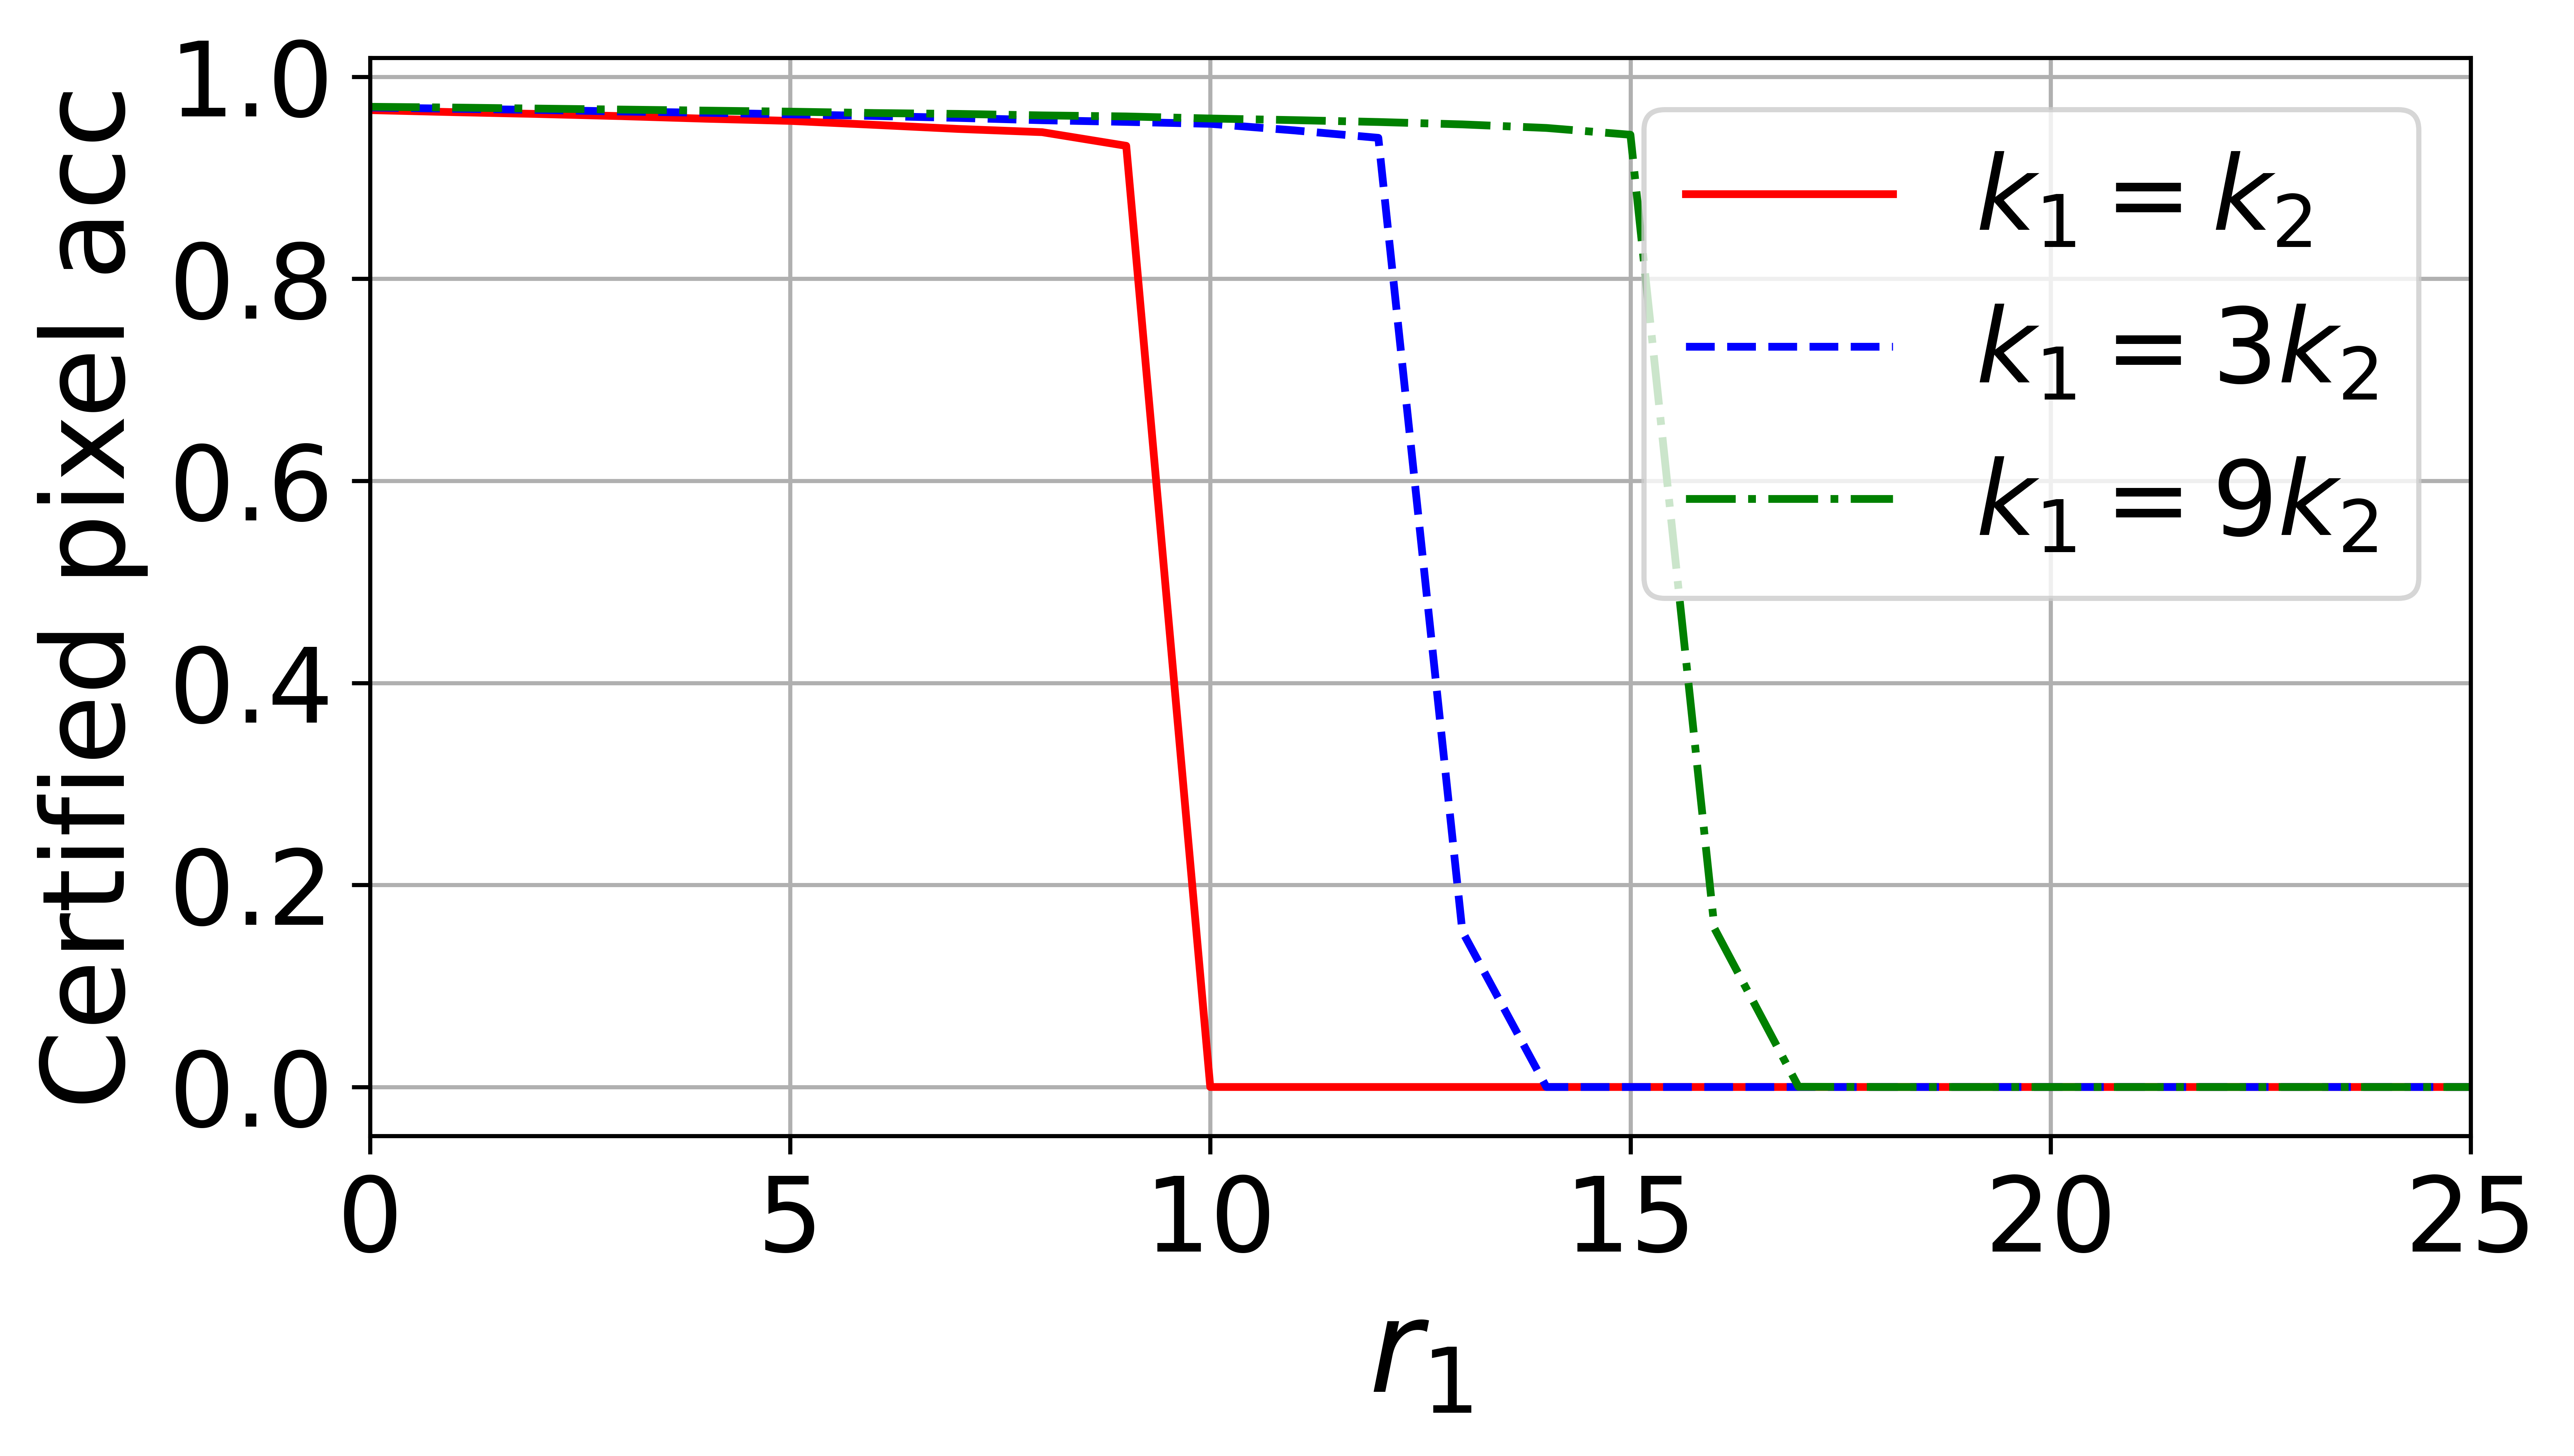

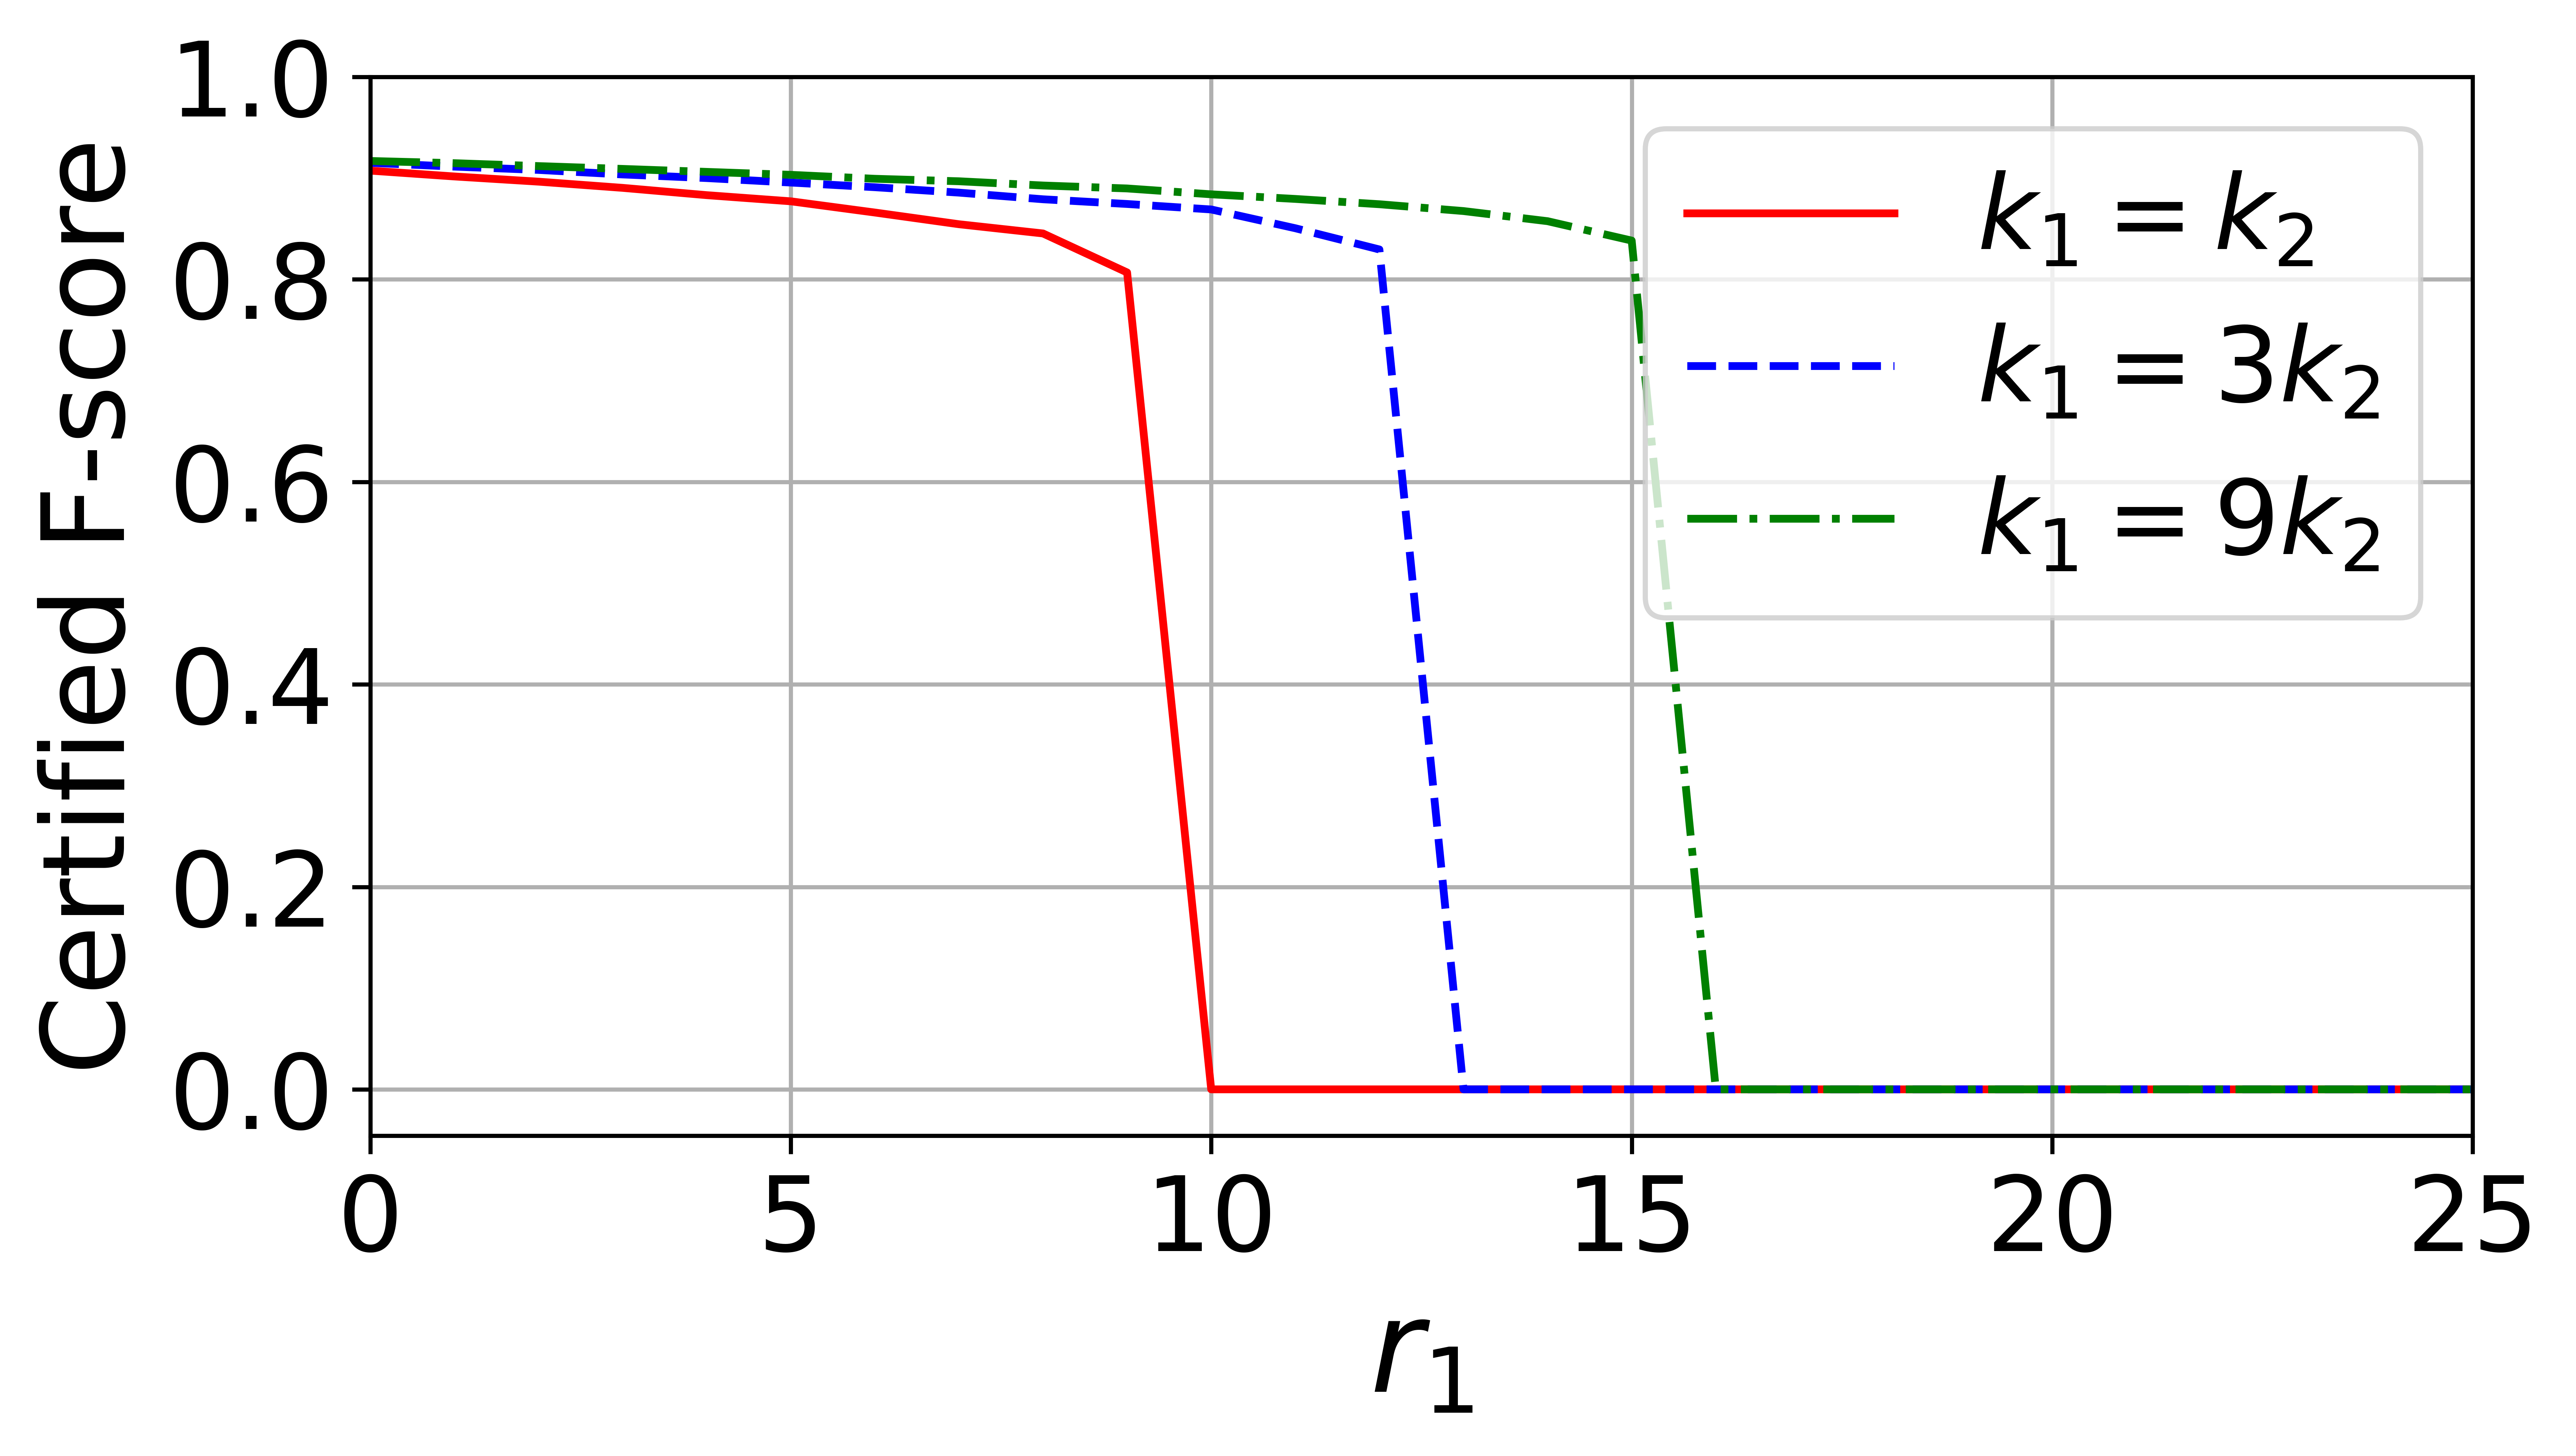

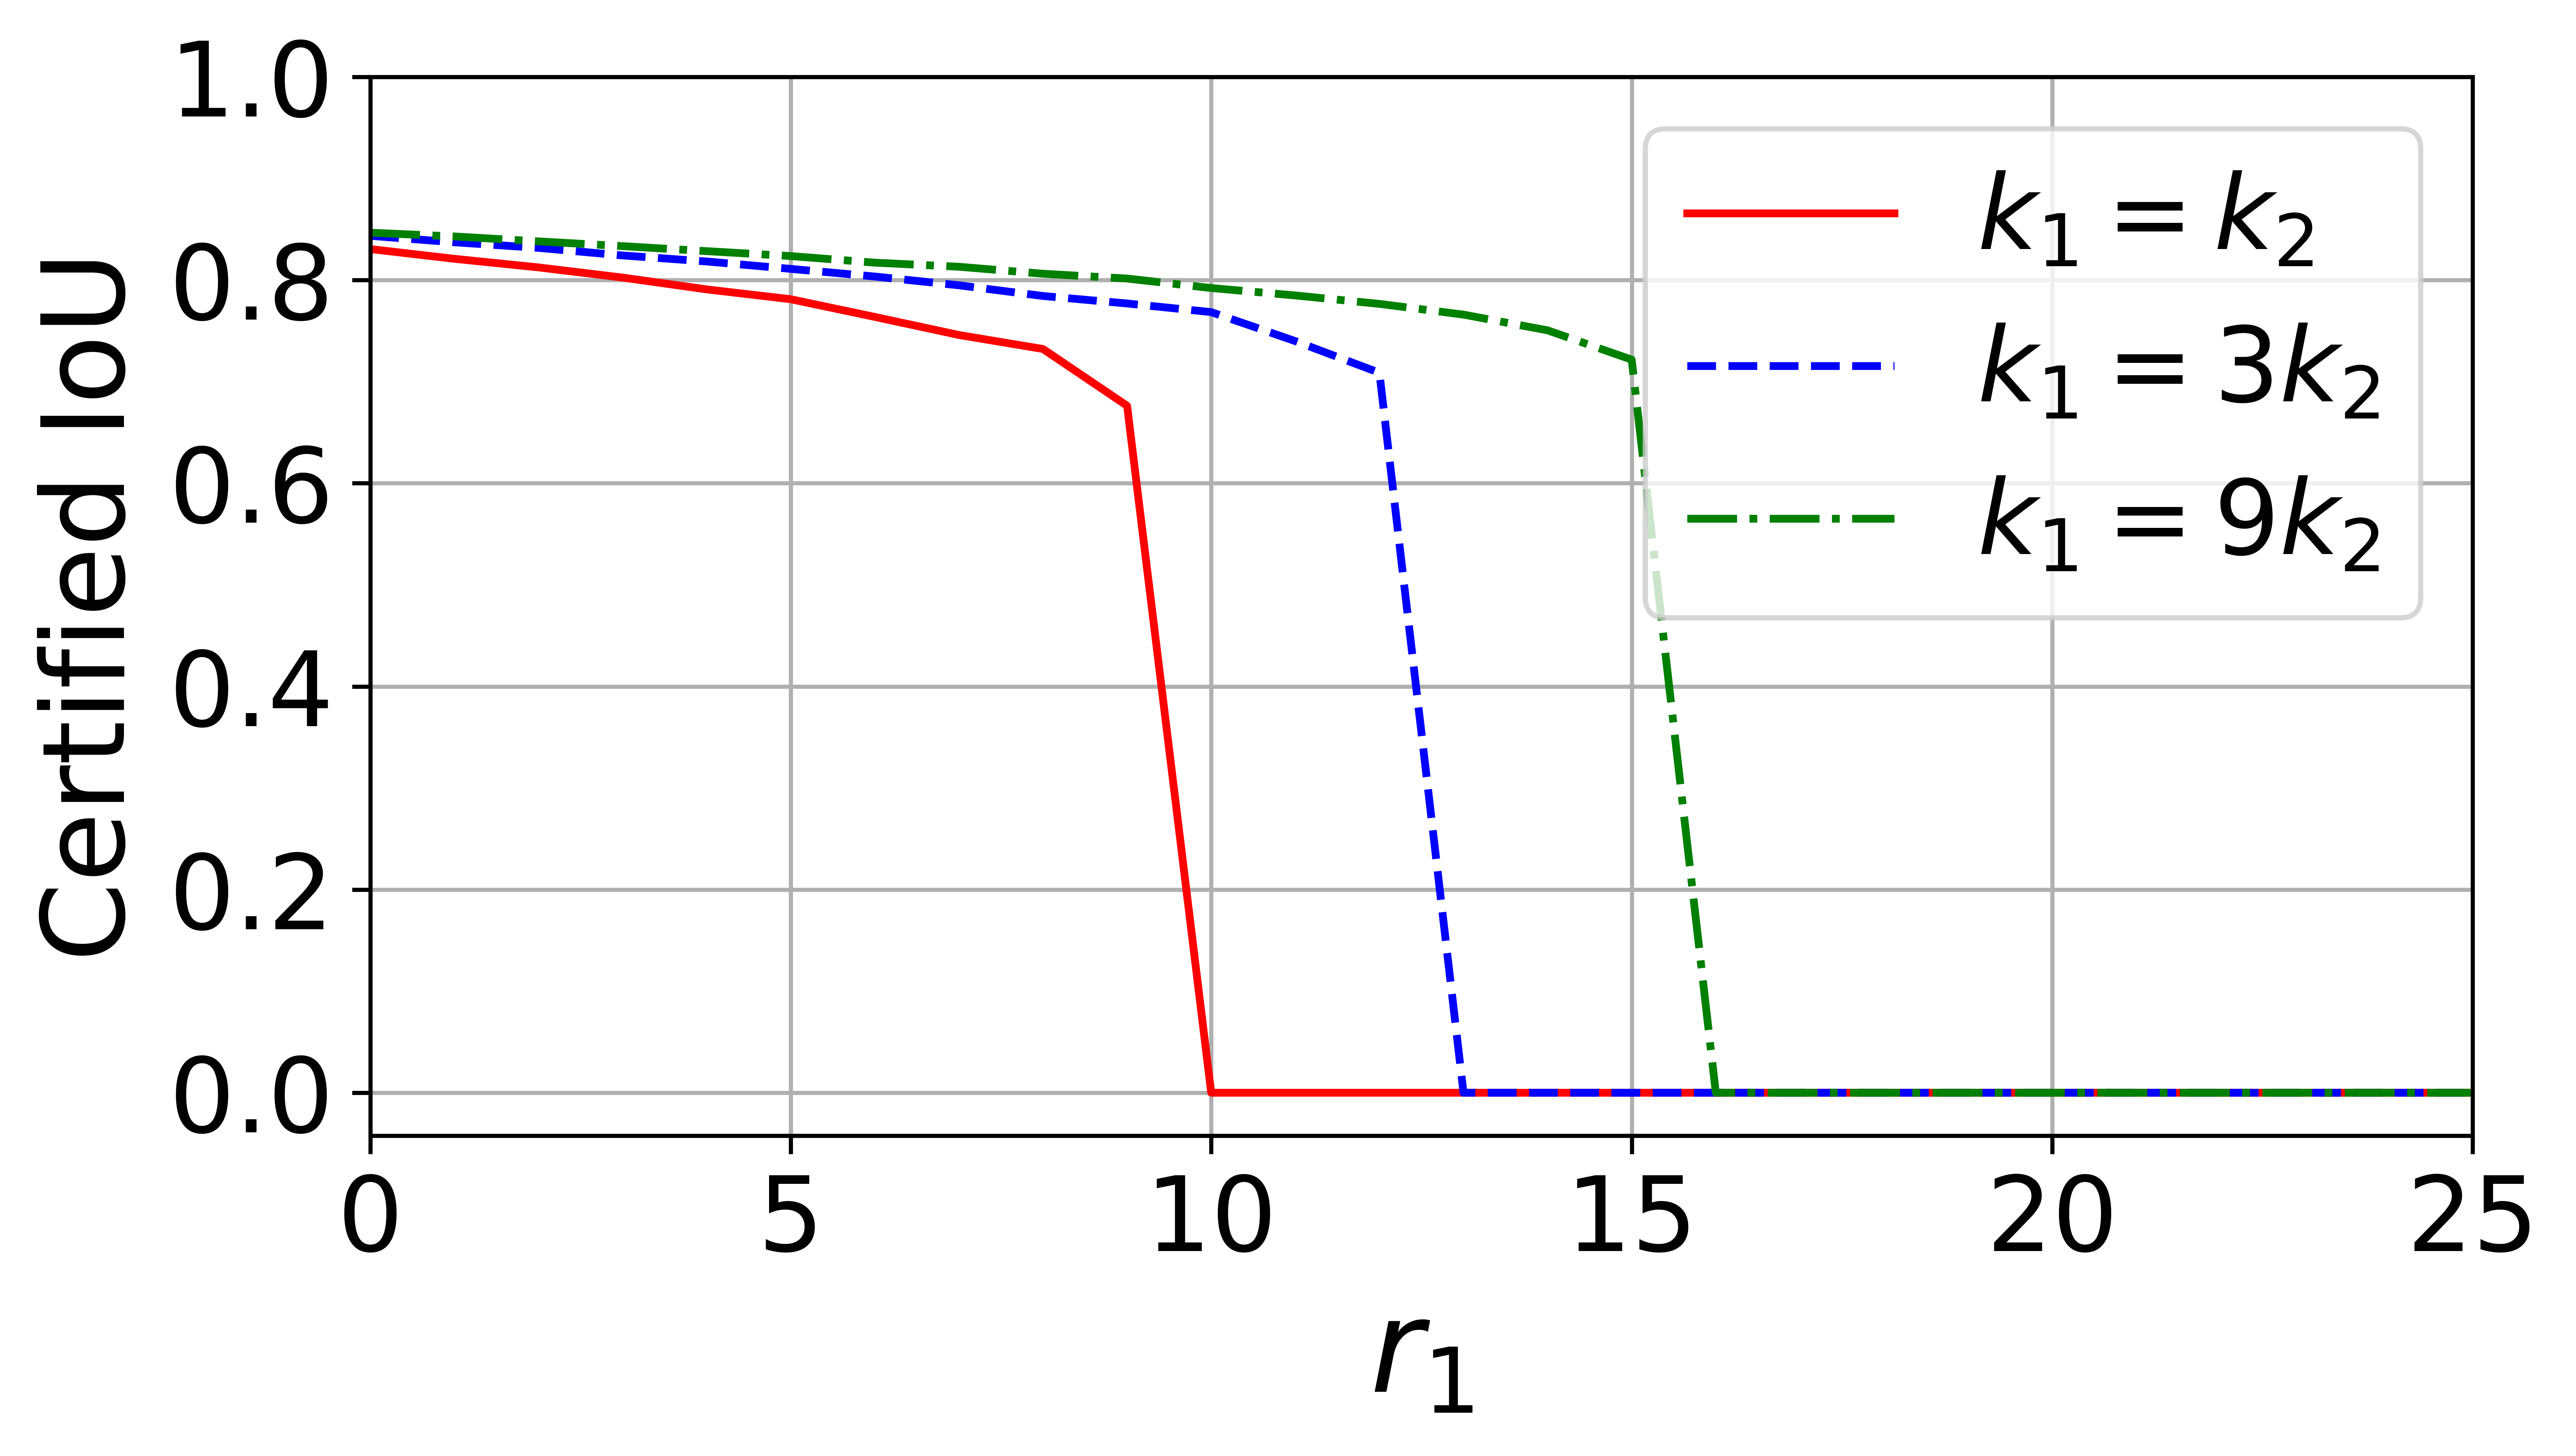

In [32]:
plt.figure(figsize = (7,4))

plt.plot( rs,certified_metrics_mmcert1[:,0], label =  r'$k_1 = k_2$',color ="red")
#plt.plot( Ts,bagging_recalls, label = 'Bagging Recall',linestyle = '--',color ="b")
plt.plot( rs,certified_metrics_mmcert2[:,0], label =  r'$k_1 = 3k_2$',linestyle = '--',color ="blue")

plt.plot( rs,certified_metrics_mmcert3[:,0], label =  r'$k_1 = 9k_2$',linestyle = '-.',color ="green")
#plt.plot( Ts,dpa_ind_recalls, label = 'DPA Recall',linestyle = 'dotted',color ="b")
#plt.plot( Ts,dpa_ind_recalls, label = 'DPA',linestyle = 'dotted',color ="g")
#plt.plot( Ts,dpa_ind_precisions, label = 'DPA Precisions',linestyle = '-.',color ="r")
if args.r2_geq_r1:
    plt.xlabel(r'$r_1$', fontsize=25)
else:
    plt.xlabel(r'$r_2$', fontsize=25)
plt.ylabel('Certified pixel acc', fontsize=22)
plt.grid()
plt.legend(loc='upper right',fontsize=20)
plt.xlim(0)
plt.xlim(xmax =6)
plt.yticks([0,0.2,0.4,0.6,0.8,1.0])
#plt.xticks([0,10,20,30,40,50,60])
plt.xticks([0,5,10,15,20,25])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.tight_layout()
plt.rcParams['figure.dpi'] = 1000
plt.tight_layout()
if args.r2_geq_r1:
    plt.savefig('figs/'+"ablation_k_pixel_accuracy"+'_r1-r2-ratio='+str(args.r1_r2_ratio)+'.pdf', dpi=1000,bbox_inches='tight')
else:
    plt.savefig('figs/'+"ablation_k_pixel_accuracy"+'_inverse-r1-r2-ratio='+str(args.inverse_r1_r2_ratio)+'.pdf', dpi=1000,bbox_inches='tight')
plt.rcParams['figure.dpi'] = 1000
plt.show()


plt.figure(figsize = (7,4))

plt.plot( rs,certified_metrics_mmcert1[:,2], label =  r'$k_1 = k_2$',color ="red")
#plt.plot( Ts,bagging_recalls, label = 'Bagging Recall',linestyle = '--',color ="b")
plt.plot( rs,certified_metrics_mmcert2[:,2], label =  r'$k_1 = 3k_2$',linestyle = '--',color ="blue")

plt.plot( rs,certified_metrics_mmcert3[:,2], label =  r'$k_1 = 9k_2$',linestyle = '-.',color ="green")

#plt.plot( Ts,dpa_ind_recalls, label = 'DPA Recall',linestyle = 'dotted',color ="b")
#plt.plot( Ts,dpa_ind_recalls, label = 'DPA',linestyle = 'dotted',color ="g")
#plt.plot( Ts,dpa_ind_precisions, label = 'DPA Precisions',linestyle = '-.',color ="r")
if args.r2_geq_r1:
    plt.xlabel(r'$r_1$', fontsize=25)
else:
    plt.xlabel(r'$r_2$', fontsize=25)
plt.ylabel('Certified F-score', fontsize=22)
plt.grid()
plt.legend(loc='upper right',fontsize=20)
plt.xlim(0)
plt.xlim(xmax =6)
plt.yticks([0,0.2,0.4,0.6,0.8,1.0])
#plt.xticks([0,10,20,30,40,50,60])
plt.xticks([0,5,10,15,20,25])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.tight_layout()
plt.rcParams['figure.dpi'] = 1000
plt.tight_layout()
if args.r2_geq_r1:
    plt.savefig('figs/'+"ablation_k_f-score"+'_r1-r2-ratio='+str(args.r1_r2_ratio)+'.pdf', dpi=1000,bbox_inches='tight')
else:
    plt.savefig('figs/'+"ablation_k_f-score"+'_inverse-r1-r2-ratio='+str(args.inverse_r1_r2_ratio)+'.pdf', dpi=1000,bbox_inches='tight')
plt.rcParams['figure.dpi'] = 1000
plt.show()

plt.figure(figsize = (7,4))

plt.plot( rs,certified_metrics_mmcert1[:,3], label =  r'$k_1 = k_2$',color ="red")
#plt.plot( Ts,bagging_recalls, label = 'Bagging Recall',linestyle = '--',color ="b")
plt.plot( rs,certified_metrics_mmcert2[:,3], label =  r'$k_1 = 3k_2$',linestyle = '--',color ="blue")

plt.plot( rs,certified_metrics_mmcert3[:,3], label =  r'$k_1 = 9k_2$',linestyle = '-.',color ="green")
#plt.plot( Ts,dpa_ind_recalls, label = 'DPA Recall',linestyle = 'dotted',color ="b")
#plt.plot( Ts,dpa_ind_recalls, label = 'DPA',linestyle = 'dotted',color ="g")
#plt.plot( Ts,dpa_ind_precisions, label = 'DPA Precisions',linestyle = '-.',color ="r")
if args.r2_geq_r1:
    plt.xlabel(r'$r_1$', fontsize=25)
else:
    plt.xlabel(r'$r_2$', fontsize=25)
plt.ylabel('Certified IoU', fontsize=22)
plt.grid()
plt.legend(loc='upper right',fontsize=20)
plt.xlim(0)
plt.xlim(xmax =6)
plt.yticks([0,0.2,0.4,0.6,0.8,1.0])
#plt.xticks([0,10,20,30,40,50,60])
plt.xticks([0,5,10,15,20,25])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.tight_layout()
plt.rcParams['figure.dpi'] = 1000
plt.tight_layout()
if args.r2_geq_r1:
    plt.savefig('figs/'+"ablation_k_iou"+'_r1-r2-ratio='+str(args.r1_r2_ratio)+'.pdf', dpi=1000,bbox_inches='tight')
else:
    plt.savefig('figs/'+"ablation_k_iou"+'_inverse-r1-r2-ratio='+str(args.inverse_r1_r2_ratio)+'.pdf', dpi=1000,bbox_inches='tight')
plt.rcParams['figure.dpi'] = 1000
plt.show()